<a href="https://colab.research.google.com/github/leabizbille/ProjetIOT/blob/main/Home_ToursHabitat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install summarytools -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.6 MB/s eta 0:00:00


In [3]:
!pip install pygwalker -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 956.2/956.2 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 35.4 MB/s eta 0:00:00


In [4]:
pip install sweetviz -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 26.3 MB/s eta 0:00:00


In [5]:
import pygwalker as pyg
from summarytools import dfSummary # module pandas-profiling
import pandas as pd
import sweetviz as sv # Module pour faire le rapport HTML
import missingno as msno

In [24]:
# Charger les fichiers CSV en conservant les titres des colonnes
THabitat2023 = pd.read_csv("/content/Tours Habitat_2023.csv",sep= ";")
THabitat2024= pd.read_csv("/content/Tours Habitat_2024.csv",sep= ";")

<Axes: >

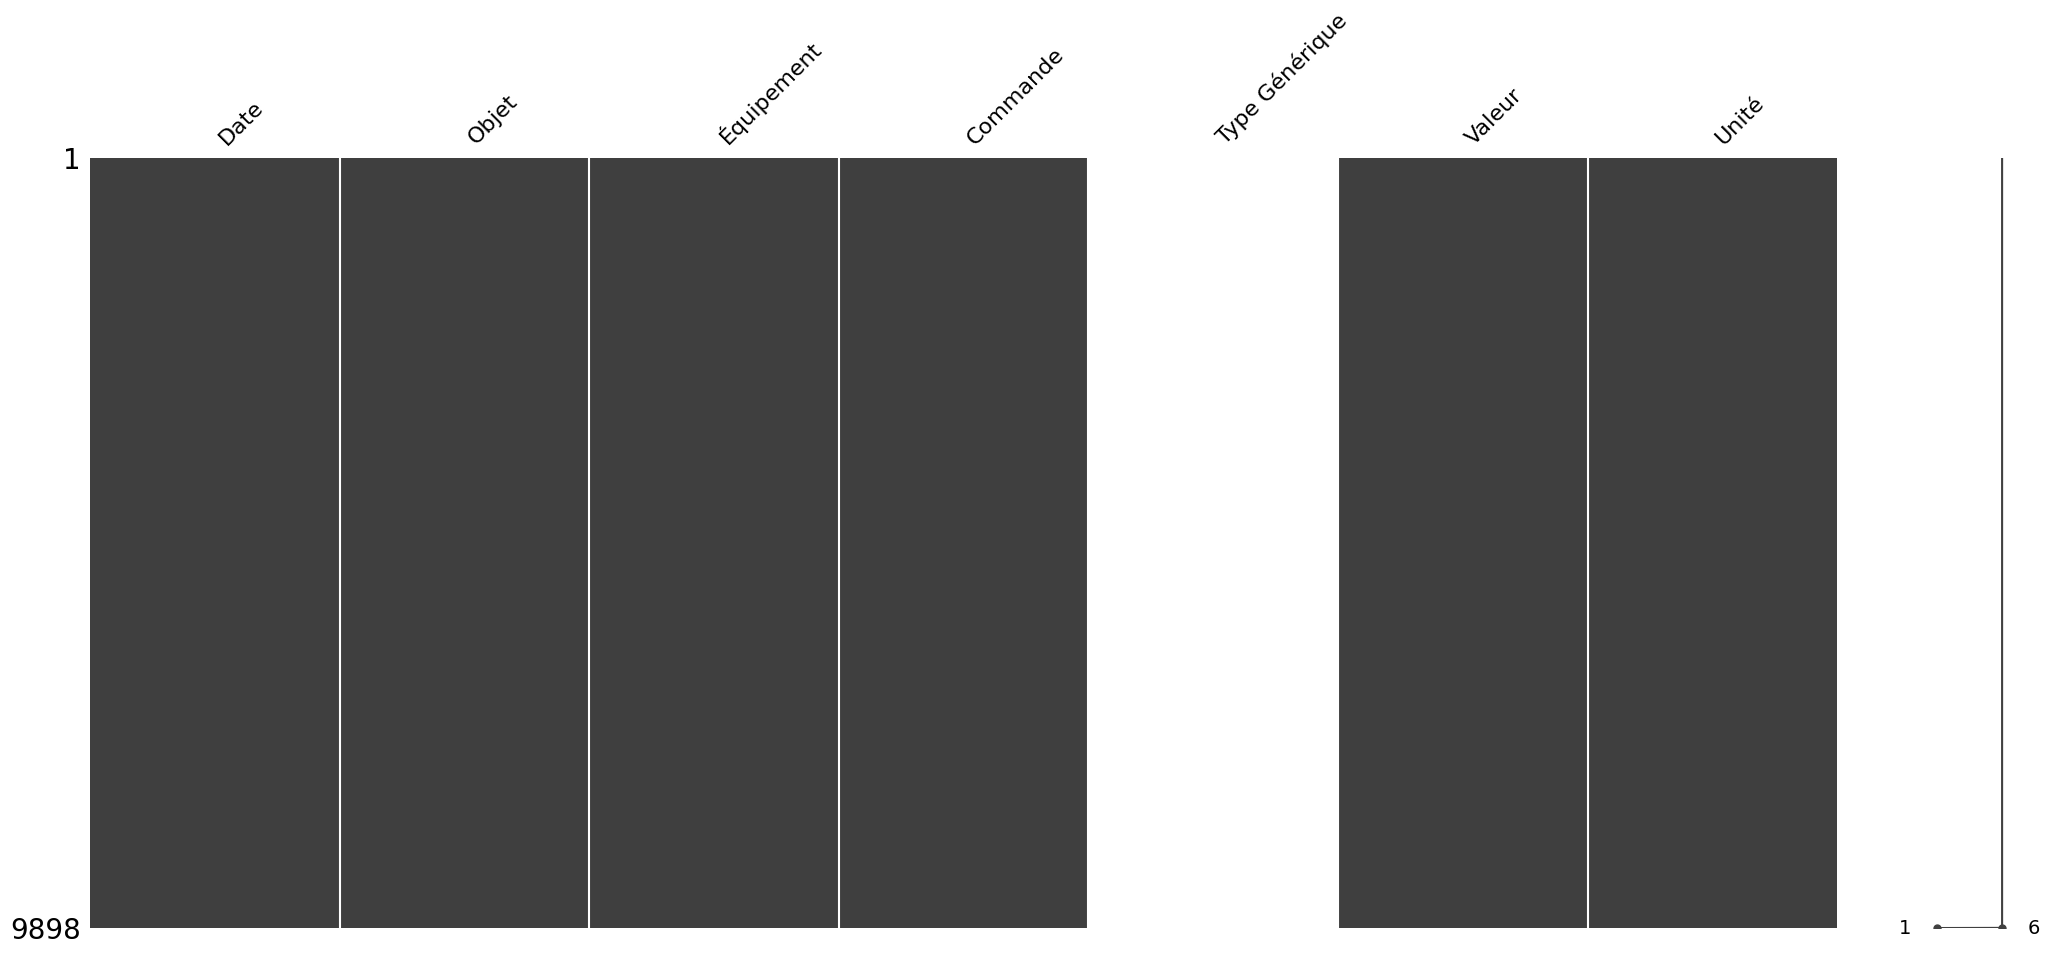

In [25]:
msno.matrix(THabitat2023)

<Axes: >

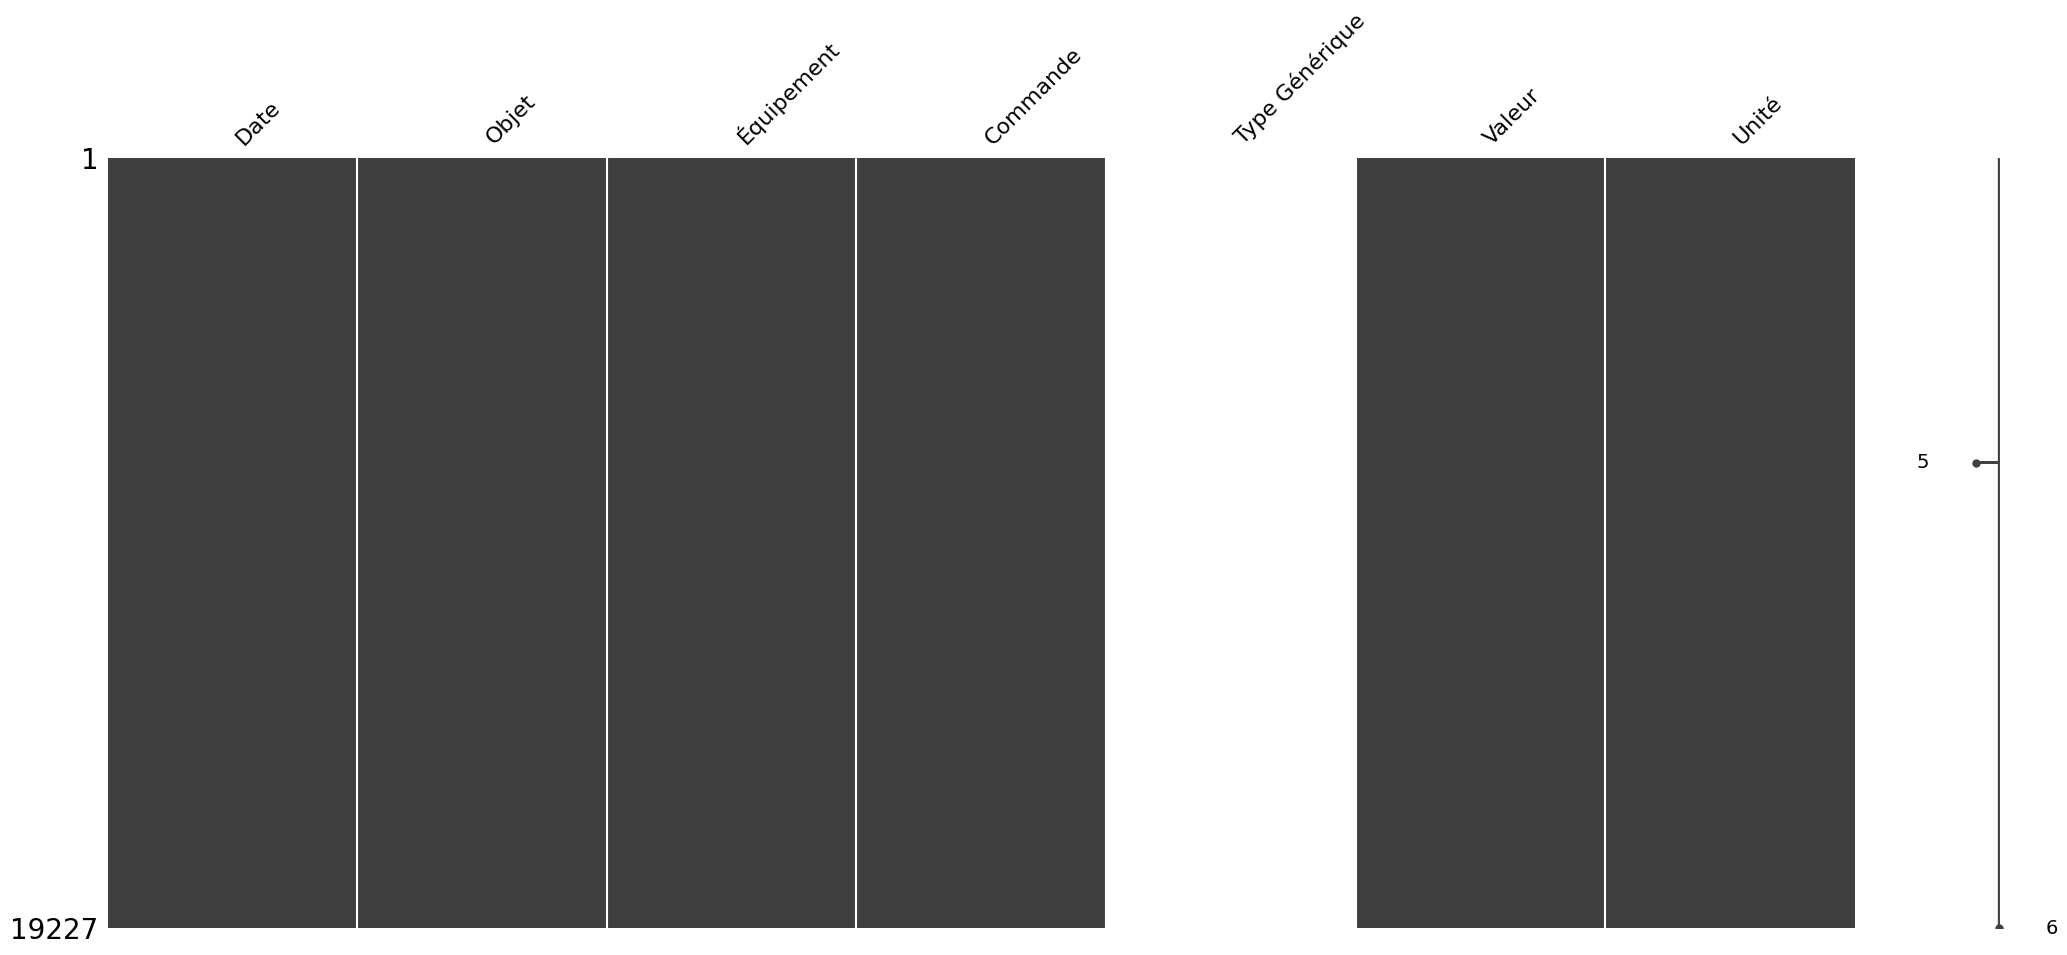

In [26]:
msno.matrix(THabitat2024)

In [27]:
# Description pour comprendre les données et mettre en suite le tableau en forme
dfSummary(THabitat2024)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Date[object],1. 2024-04-10 10:00:052. 2024-01-10 19:00:063. 2024-01-24 16:22:054. 2024-04-30 19:00:065. 2024-04-29 21:00:056. 2024-03-19 10:00:067. 2024-04-04 21:00:078. 2024-04-30 03:00:069. 2024-05-05 01:00:0810. 2024-05-04 17:00:0711. other,"10 (0.1%)9 (0.0%)9 (0.0%)8 (0.0%)8 (0.0%)8 (0.0%)8 (0.0%)8 (0.0%)8 (0.0%)8 (0.0%)19,143 (99.6%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADQklEQVR4nO3cwWkbYRRG0TdCJPZGQghUQtKDisg2HauINGGkReJ44yyCS8gdmJxTwb+48BDMp+X9/X2gsFv7Afw/xEZGbGTERkZsZMRGRmxkxEZGbGTERma3LMvXZVme1n4I27ebmS8z83nth7B9zigZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkdnNzI+Z+b32Q9i+xb8YUXFGyYiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyIiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhklIzYyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsa6iox1FRlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhkls8zM88x8WvshbN7b/nw+fzscDqe1X8K2PR6Pl/3hcDhdr9dfx+Pxde0HsU33+/3pdrud9jMzx+Px9XK5/Fz7UWzasx8IZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZPYzfz8BWfshbNdHX8v5fP7u40n+tcfj8eKzcCpv1lVk/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiPzB0WpV2yec8bJAAAAAElFTkSuQmCC"">",0(0.0%)
2,Objet[object],1. Données calculées,"19,227 (100.0%)",,0(0.0%)
3,Équipement[object],1. Conso horaire 1er Etage_1204092. Conso horaire RDC_120404_FCH3. Conso horaire RDC_12044B_FCH4. Conso horaire E2_120417_FCH5. Conso horaire RDC_12044E_FCH,"7,604 (39.5%)4,962 (25.8%)4,063 (21.1%)2,311 (12.0%)287 (1.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABzCAYAAACPdnBjAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACYklEQVR4nO3bQYoaURiF0V+RTpyUiOAyXEAvIovNIlyA+xCxBrHTEzNICJl0N4Tyvuqqc1bwhI+SV9Rd3O/3goRl6wMwH2IjRmzELKpqXVVPrQ8S9nq/32+tDzE3q91u963rum3rgyT1fX9ZLBbfBZe16rpu+/z8fNtsNi+tD5NwvV6/Ho/H7fl8fqoqsQWtqqo2m83Lfr//0fowQevWB5gjFwRixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2ZV9fuzm9YHSZnTbx2bVd/3l+PxuK0ZfXbT9/2lql5bn2NufBZOzMJulBQXBGI+w9+ov7yJGP26yhJqOka9rrKEmpbPsK6azSuZqXNBIEZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZiRr2uGuu5+D+jX1dZQk2Hz8KJsa4ixgWBmLH8jfqrnIFRrKssqOah+brKgmo+xrKuGuVrF4blgkCM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxDRfV1lQzcco1lUWVPPgs3BirKuIGfrJ5gnFmwYdvBiu8J7BBi+GK3xk6MGL4Qpv8lKXGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzGDrauspPjIoOsqKyneY4NAjHUVMf8+2TyVeKi/6yrLKB5t2XXd9nA41J85X+tlPBO2rKpar9c/Wx+E6fNSlxixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxy6qq2+32pfVBmL5l3/eX0+lkGcXD2SAQY11FjAsCMWIj5heO4v8NNfN6wgAAAABJRU5ErkJggg=="">",0(0.0%)
4,Commande[object],1. Conso E2 Tableau Général2. Conso E1 Tableau général3. Conso E1 Bureaux4. Conso E1 Eclairage5. Conso E1 Circulation6. Conso RDC Armoire37. Conso RDC Armoire58. Conso RDC VMC Ateliers9. Conso RDC Armoire110. Conso RDC Tab Lumières Général11. other,"2,310 (12.0%)2,228 (11.6%)2,009 (10.4%)1,698 (8.8%)1,395 (7.3%)1,251 (6.5%)1,243 (6.5%)1,242 (6.5%)1,226 (6.4%)1,019 (5.3%)3,606 (18.8%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAECUlEQVR4nO3dQWrjWABF0e/ChK6JTQhkMVlEL7YW4d2EEA26ipq4Bz3sJpGsz22Iz1mAyODyjYRedLherwMK3/7vP4D7ITYyYiMjNjJiIyM2MmIjIzYyYiNzGGN8H2M8TLre7+v1+nPStfhijk9PT3+eTqfHGRdbluXtcDj8EBz/5Xg6nR5fXl5+ns/nX3su9P7+/sflcnl8fX19GGOIjX85jjHG+Xz+9fz8/NeE632fcA2+KDcIZMRGRmxkxEZ

In [28]:
# Description pour comprendre les données et mettre en suite le tableau en forme
dfSummary(THabitat2024)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Date[object],1. 2024-04-10 10:00:052. 2024-01-10 19:00:063. 2024-01-24 16:22:054. 2024-04-30 19:00:065. 2024-04-29 21:00:056. 2024-03-19 10:00:067. 2024-04-04 21:00:078. 2024-04-30 03:00:069. 2024-05-05 01:00:0810. 2024-05-04 17:00:0711. other,"10 (0.1%)9 (0.0%)9 (0.0%)8 (0.0%)8 (0.0%)8 (0.0%)8 (0.0%)8 (0.0%)8 (0.0%)8 (0.0%)19,143 (99.6%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADQklEQVR4nO3cwWkbYRRG0TdCJPZGQghUQtKDisg2HauINGGkReJ44yyCS8gdmJxTwb+48BDMp+X9/X2gsFv7Afw/xEZGbGTERkZsZMRGRmxkxEZGbGTERma3LMvXZVme1n4I27ebmS8z83nth7B9zigZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkdnNzI+Z+b32Q9i+xb8YUXFGyYiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyIiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhklIzYyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsa6iox1FRlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhkls8zM88x8WvshbN7b/nw+fzscDqe1X8K2PR6Pl/3hcDhdr9dfx+Pxde0HsU33+/3pdrud9jMzx+Px9XK5/Fz7UWzasx8IZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZPYzfz8BWfshbNdHX8v5fP7u40n+tcfj8eKzcCpv1lVk/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiPzB0WpV2yec8bJAAAAAElFTkSuQmCC"">",0(0.0%)
2,Objet[object],1. Données calculées,"19,227 (100.0%)",,0(0.0%)
3,Équipement[object],1. Conso horaire 1er Etage_1204092. Conso horaire RDC_120404_FCH3. Conso horaire RDC_12044B_FCH4. Conso horaire E2_120417_FCH5. Conso horaire RDC_12044E_FCH,"7,604 (39.5%)4,962 (25.8%)4,063 (21.1%)2,311 (12.0%)287 (1.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABzCAYAAACPdnBjAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACYklEQVR4nO3bQYoaURiF0V+RTpyUiOAyXEAvIovNIlyA+xCxBrHTEzNICJl0N4Tyvuqqc1bwhI+SV9Rd3O/3goRl6wMwH2IjRmzELKpqXVVPrQ8S9nq/32+tDzE3q91u963rum3rgyT1fX9ZLBbfBZe16rpu+/z8fNtsNi+tD5NwvV6/Ho/H7fl8fqoqsQWtqqo2m83Lfr//0fowQevWB5gjFwRixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2ZV9fuzm9YHSZnTbx2bVd/3l+PxuK0ZfXbT9/2lql5bn2NufBZOzMJulBQXBGI+w9+ov7yJGP26yhJqOka9rrKEmpbPsK6azSuZqXNBIEZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZiRr2uGuu5+D+jX1dZQk2Hz8KJsa4ixgWBmLH8jfqrnIFRrKssqOah+brKgmo+xrKuGuVrF4blgkCM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxDRfV1lQzcco1lUWVPPgs3BirKuIGfrJ5gnFmwYdvBiu8J7BBi+GK3xk6MGL4Qpv8lKXGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzGDrauspPjIoOsqKyneY4NAjHUVMf8+2TyVeKi/6yrLKB5t2XXd9nA41J85X+tlPBO2rKpar9c/Wx+E6fNSlxixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxy6qq2+32pfVBmL5l3/eX0+lkGcXD2SAQY11FjAsCMWIj5heO4v8NNfN6wgAAAABJRU5ErkJggg=="">",0(0.0%)
4,Commande[object],1. Conso E2 Tableau Général2. Conso E1 Tableau général3. Conso E1 Bureaux4. Conso E1 Eclairage5. Conso E1 Circulation6. Conso RDC Armoire37. Conso RDC Armoire58. Conso RDC VMC Ateliers9. Conso RDC Armoire110. Conso RDC Tab Lumières Général11. other,"2,310 (12.0%)2,228 (11.6%)2,009 (10.4%)1,698 (8.8%)1,395 (7.3%)1,251 (6.5%)1,243 (6.5%)1,242 (6.5%)1,226 (6.4%)1,019 (5.3%)3,606 (18.8%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAECUlEQVR4nO3dQWrjWABF0e/ChK6JTQhkMVlEL7YW4d2EEA26ipq4Bz3sJpGsz22Iz1mAyODyjYRedLherwMK3/7vP4D7ITYyYiMjNjJiIyM2MmIjIzYyYiNzGGN8H2M8TLre7+v1+nPStfhijk9PT3+eTqfHGRdbluXtcDj8EBz/5Xg6nR5fXl5+ns/nX3su9P7+/sflcnl8fX19GGOIjX85jjHG+Xz+9fz8/NeE632fcA2+KDcIZMRGRmxkxEZ

- 1 nan dans les Unités -> regarder pour faire des modifications
- 100 % de donnée manquante dans "Type Générique".
- Deux fichiers sous le même format

Pour toutes les colonnes, reformater les données.
Un pivotement ou une transposition du tableau sera probablement nécessaire.

Fusionner les deux tableaux.


In [29]:
# Fusionner les deux DataFrames
Tours_Habitat= pd.concat([THabitat2023, THabitat2024], ignore_index=True)

# Sauvegarder le fichier fusionné si nécessaire
Tours_Habitat.to_csv('Tours_Habitat_fusionne.csv', index=False)

In [30]:
# Séparer la colonne 'datetime' en deux colonnes distinctes
Tours_Habitat[['date', 'time']] = Tours_Habitat['Date'].str.split(' ', expand=True)

In [46]:
Tours_Habitat['time'] = pd.to_datetime(Tours_Habitat['time'], format='%H:%M:%S').dt.time

In [34]:
# Conversion avec gestion des formats mixtes
try:
    Tours_Habitat['date'] = pd.to_datetime(
        Tours_Habitat['date'], errors='coerce', format='mixed'
    )
except ValueError:
    # Si l'erreur persiste, identifier les valeurs problématiques
    invalid_dates = Tours_Habitat['date'][~pd.to_datetime(Tours_Habitat['date'], errors='coerce').notna()]
    print("Dates invalides :", invalid_dates)

# Identifier et corriger les valeurs problématiques manuellement si nécessaire

In [35]:
Tours_Habitat['annee'] = pd.to_datetime(Tours_Habitat['date']).dt.year

In [36]:
# Convertir les nouvelles colonnes au format datetime
Tours_Habitat['date'] = pd.to_datetime(Tours_Habitat['date'], format='%Y-%m-%d')


In [47]:
# Description pour comprendre les données et mettre en suite le tableau en forme
dfSummary(Tours_Habitat)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Date[object],1. 2024-04-10 10:00:052. 2024-01-24 16:22:053. 2024-01-10 19:00:064. 2024-04-17 01:00:075. 2024-05-04 17:00:076. 2024-04-10 23:00:057. 2024-03-19 10:00:068. 2024-05-05 01:00:089. 2024-04-22 10:00:0610. 2024-04-22 16:00:0711. other,"10 (0.0%)9 (0.0%)9 (0.0%)8 (0.0%)8 (0.0%)8 (0.0%)8 (0.0%)8 (0.0%)8 (0.0%)8 (0.0%)29,041 (99.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,Objet[object],1. Données calculées2. nan,"29,124 (100.0%)1 (0.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAA/0lEQVR4nO3bwUkEMQBG4T/DoOslYQlMCdrDFuHV3u0iF11P48EafIHs+yr4Dw9CICnneUYilCQvSZ5mD9H69t77e631OnuI1rfXWq+32+27tXafPUbrGmNc9iRprd2P4/iaPUhr22YP0OMwNmGMTRhjE8bYhDE2YYxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTZg9+XvYNnuI1jbGuJTe+4fPwkXww4swxa98onhBEGYrpbyVUrwg6N9tSV6TPM8eovV5jApjbMIYmzDGJoyxCWNswhibMMYmjLEJY2zCGJswxiaMsQljbMIYmzDGJoyxCbMl+UzyM3uI1ufvKmF+AXVbGymqDU4XAAAAAElFTkSuQmCC"">",1(0.0%)
3,Équipement[object],1. 1er Etage_120409_FCH2. RDC_120404_FCH3. RDC_12044B_FCH4. E2_120417_FCH5. RDC_12044E_FCH6. nan,"17,501 (60.1%)4,962 (17.0%)4,063 (14.0%)2,311 (7.9%)287 (1.0%)1 (0.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAACKCAYAAAC96ziyAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACuklEQVR4nO3dQWrbUBiF0V/CpPVExgSyhHaWBWQRXWwX4QVk2D0EEw3qNBN30FI3IRM76D7IO2cFj/BZQkbXGY7HY0HC2PoA9ENsxIiNGLERM1TVuqquWh+kM8/H4/HQ+hBpq+vr62/TNG1bH6Qn8zzvh2H43ltwq2matnd3d4fNZvPU+jA9eHx8/Lzb7bYPDw9XVdVXbFVVm83m6ebm5mfrw3Rk3foALXhAIEZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZiVlV/XntpfZBe9Py3Xs3zvN/tdtvq9LWXFuZ53lfVc+tzpHktvI0uXwsfjJRJSV7Zuvw0cxIbvPQ68uAkMnjpeeTBSXLw4mm3c77UJUZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEZMZF3V86KIk9i6qtdFESc2CMRYVxGz5JXNlYwXFltXWVPx2iLrKmsq3rLkusqaihd8qUuM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNmEXWVdZUvGWxdZU1Fa/ZIBBjXUXMJVc2Vywucva6ymqKS521rrKa4j0uWVdZTXERX+oSIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFnDV4MWXiPswcvhixcymvhxBi8EOMBgZj/b6Nujyzq37rKaoqljdM0bW9vb+vvnC/xf0fp1FhVtV6vf7U+CB+fBwRixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2asqjocDp9aH4SPb5zneX9/f281xeK8Fk6MdRUxHhCIGYdh+DoMg59VYHFjVX2pKk+jLM5tlBixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSMVfWjqvyAM4szeCHGbZQYsREjNmLERsxv8l8Ee99HkDkAAAAASUVORK5CYII="">",1(0.0%)
4,Commande[object],1. Conso E1 Bureaux2. Conso E1 Circulation3. Conso E1 Eclairage4. Conso E2 Tableau Général5. Conso E1 Tableau général6. Conso RDC Armoire37. Conso RDC Armoire58. Conso RDC VMC Ateliers9. Conso RDC Armoire110. Conso RD

Les colonnes Objet et Type Générique n'apportent aucune informations :

In [48]:
# Supprimer l'ancienne colonne si elle n'est plus nécessaire
Tours_Habitat= Tours_Habitat.drop(columns=['Type Générique'])
Tours_Habitat= Tours_Habitat.drop(columns=['Objet'])

Recherche des modalités dans la colonne "Equipement".

In [49]:
# Trouver toutes les modalités uniques dans la colonne 'Équipement'
modalites = Tours_Habitat['Équipement'].unique()

# Afficher les modalités
print(modalites)

['1er Etage_120409_FCH' nan 'E2_120417_FCH' 'RDC_120404_FCH'
 'RDC_12044B_FCH' 'RDC_12044E_FCH']


La colonne "Equipement" ne correspond pas à des équipements éléctriques mais à des consommations éléctrique / heure, de plusieurs lieux.

In [39]:
# Supprimer "Conso horaire" et séparer les informations autour du "_"
Tours_Habitat['Équipement'] = Tours_Habitat['Équipement'].str.replace('Conso horaire ', '', regex=False)

Séparation et création de plusieurs colonnes : Une pour le "niveau", soit l'étage du batiment. Une pour la pièce " Num_Pièce" et la dernière avec "FCH".

In [50]:
Tours_Habitat[['Niveau', 'Num_Piece', 'FCH']] = Tours_Habitat['Équipement'].str.split('_', expand=True)

Nettoyage colonne Commande :

In [56]:
# Trouver toutes les modalités uniques dans la colonne 'Équipement'
modalites = Tours_Habitat['Commande'].unique()

# Afficher les modalités
print(modalites)

[' E1 Bureaux' ' E1 Circulation' ' E1 Eclairage' 'nan' ' E1 Seche Main F'
 ' E1 Seche Main H' ' E1 Tableau général' ' E2 Coffret'
 ' E2 Tableau Général' ' RDC Armoire1' ' RDC Armoire3' ' RDC Armoire5'
 ' RDC VMC Ateliers' ' RDC Bureau S6' ' RDC Climatisation'
 ' RDC Sous-station' ' RDC Tab Lumières Général' ' RDC Ascenseur'
 ' RDC Rideau d’air chaud']


Beaucoup de modalité, et toutes commencent pas "Conso", sachant que les unité sont déjà porteuses de l'information, car nous avons des Kw/heures, et que l'ensemble des données sont des "conso", nous enlèvons le mot "conso" de la colonne.

In [52]:
# Supprimer "Conso"
Tours_Habitat['Commande'] = Tours_Habitat['Commande'].str.replace('Conso', '', regex=False)

In [41]:
Tours_Habitat['Commande'] = Tours_Habitat['Commande'].astype(str)

In [53]:
# Séparer les valeurs avant et après le premier espace
Tours_Habitat[['Etage', 'Objets']] = Tours_Habitat['Commande'].str.split(n=1, expand=True)

In [54]:
# Supprimer l'ancienne colonne si elle n'est plus nécessaire
Tours_Habitat= Tours_Habitat.drop(columns=['FCH'])
Tours_Habitat= Tours_Habitat.drop(columns=['Niveau'])

In [73]:
dfSummary(Tours_Habitat)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Date[object],1. 2024-04-10 10:00:052. 2024-01-24 16:22:053. 2024-01-10 19:00:064. 2024-04-17 01:00:075. 2024-05-04 17:00:076. 2024-04-10 23:00:057. 2024-03-19 10:00:068. 2024-05-05 01:00:089. 2024-04-22 10:00:0610. 2024-04-22 16:00:0711. other,"10 (0.0%)9 (0.0%)9 (0.0%)8 (0.0%)8 (0.0%)8 (0.0%)8 (0.0%)8 (0.0%)8 (0.0%)8 (0.0%)29,039 (99.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,Équipement[object],1. 1er Etage_120409_FCH2. RDC_120404_FCH3. RDC_12044B_FCH4. E2_120417_FCH5. RDC_12044E_FCH,"17,501 (60.1%)4,962 (17.0%)4,063 (14.0%)2,310 (7.9%)287 (1.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABzCAYAAACPdnBjAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACZElEQVR4nO3dUWoaURiG4V+RtN6MiOAysoAsoovtIlyA+xBxLmqaG3vRUJuQGw3zHch5nhUcwssMI+cjs8vlUpAwb30A+iE2YsRGzKyqllX10PognXm5XC7n1odIW2w2mx/DMKxbH6Qn4zgeZ7PZz96CWwzDsH56ejqvVqvn1ofpwel0+r7b7daHw+GhqvqKrapqtVo9b7fbX60P05Fl6wO04AOBGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IhZVP299tL6IL3o+W+9GMfxuNvt1tXptZcWxnE8VtVL63OkuRbeRpfXwmd2o6T4QCAm+Rrt8tXBVWxd1euiiKvIuqrnRRFXyXWVn1Y65wOBGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IiJrKt6XhRxFVtX9boo4sq1cGKsq4jxgUDMlK9Rr03emGxdZU3Fe5Osq6yp+MiU6yprKt7wgUCM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxEyyrrKm4iOTrausqXjPtXBirKuIuefJ5onFXW4evBiycK+bBi+GLHzGPYMXQxbu4kddYsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMTctK6ymuIzbl5XWU1xLxsEYqyriPn/yeaJxaT+rausppjafBiG9ePjY73O+RL/d5ROzauqlsvl79YH4evzoy4xYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YuZVVefz+Vvrg/D1zcdxPO73e6spJmeDQIx1FTE+EIgRGzF/AI7i/w0XtU0YAAAAAElFTkSuQmCC"">",0(0.0%)
3,Commande[object],1. E1 Bureaux2. E1 Circulation3. E1 Eclairage4. E2 Tableau Général5. E1 Tableau général6. RDC Armoire37. RDC Armoire58. RDC VMC Ateliers9. RDC Armoire110. RDC Tab Lumières Général11. other,"5,993 (20.6%)4,686 (16.1%)4,320 (14.8%)2,310 (7.9%)2,228 (7.7%)1,251 (4.3%)1,243 (4.3%)1,242 (4.3%)1,226 (4.2%)1,019 (3.5%)3,605 (12.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAD8ElEQVR4nO3dQWoTYQCG4T8SRDcJpdDD9BAe1kPkNqV0Fipu4kIUsSZhYuYd0Oe5wGTx8pcZ5utsjsfjgMKbtX8A/w+xkREbGbGRERsZsZERGxmxkREbmc0Y4/0Y4+2Kv+Hr8Xj8vOL1iWzv7+8/7Ha7u7V+wDRNz5vN5qPg/n3b3W539/j4+Hm/33+pL/7y8vLucDjcPT09vR1jiO0ftx1jjP1+/+Xh4eHTSr/h/UrXJeYGgYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyGzH+P5e2RoXX+u6rGM7TdPz4XC4Gyu9VzZN0/MY4+sa16Zlg0Bm419mUalONqcXzbrKgooxgnWVBRU/VOsqCyo81KUjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiOz+ODFqIUfksGLUQtjeC2ckMELmaVPNicaPy06eDF04VeLDV4MXfjd0

In [72]:
# Trouver toutes les modalités uniques dans la colonne 'Équipement'
modalites = Tours_Habitat['Objets'].unique()

# Afficher les modalités
print(modalites)

['Bureaux' 'Circulation' 'Eclairage' 'Seche_Main_F' 'Seche_Main_H'
 'Tableau_Général' 'Armoire1' 'Armoire3' 'Armoire5' 'VMC_Ateliers'
 'Bureau_S6' 'Climatisation' 'Sous-station' 'Tab_Lumières_Général'
 'Ascenseur' 'Rideau_d’air_chaud']


In [66]:
# Fonction de nettoyage améliorée
def nettoyer_objets(data):
    if isinstance(data, str):  # Vérifie que la donnée est bien une chaîne de caractères
        data = data.strip()  # Supprime les espaces au début et à la fin
        if data.lower() == 'tableau général':  # Vérifie sans tenir compte des majuscules/minuscules
            return 'Tableau Général'
        else:
            return data  # Retourne la valeur inchangée si elle ne correspond à aucun cas
    return data  # Retourne la donnée inchangée si ce n'est pas une chaîne

# Appliquer la fonction de nettoyage à la colonne 'Objets'
Tours_Habitat['Objets'] = Tours_Habitat['Objets'].apply(nettoyer_objets)


In [67]:
# Fonction de nettoyage pour remplacer les espaces par des underscores
def remplacer_espaces(data):
    if isinstance(data, str):  # Vérifie que la donnée est une chaîne de caractères
        return data.replace(' ', '_')  # Remplace les espaces par des underscores
    return data  # Retourne la donnée inchangée si ce n'est pas une chaîne

# Appliquer la fonction à la colonne 'Objets'
Tours_Habitat['Objets'] = Tours_Habitat['Objets'].apply(remplacer_espaces)


In [71]:
# Filtrer les lignes contenant au moins un NaN
lignes_avec_nan = Tours_Habitat[Tours_Habitat.isnull().any(axis=1)]

# Afficher ces lignes
print(lignes_avec_nan)


Empty DataFrame
Columns: [Date, Équipement, Commande, Valeur, Unité, date, time, annee, Num_Piece, Etage, Objets]
Index: []


Ici, la donnée "Coffret" est unique et a une valeur de 0. La seconde ligne est entièrement vide. Nous allons donc supprimer ces deux lignes, jugées inutiles

In [70]:
# Supprimer les lignes contenant au moins un NaN
Tours_Habitat = Tours_Habitat.dropna()

arret !

In [ ]:
# Supprimer l'ancienne colonne
val_roland= val_roland.drop(columns=['Objet'])

<Axes: >

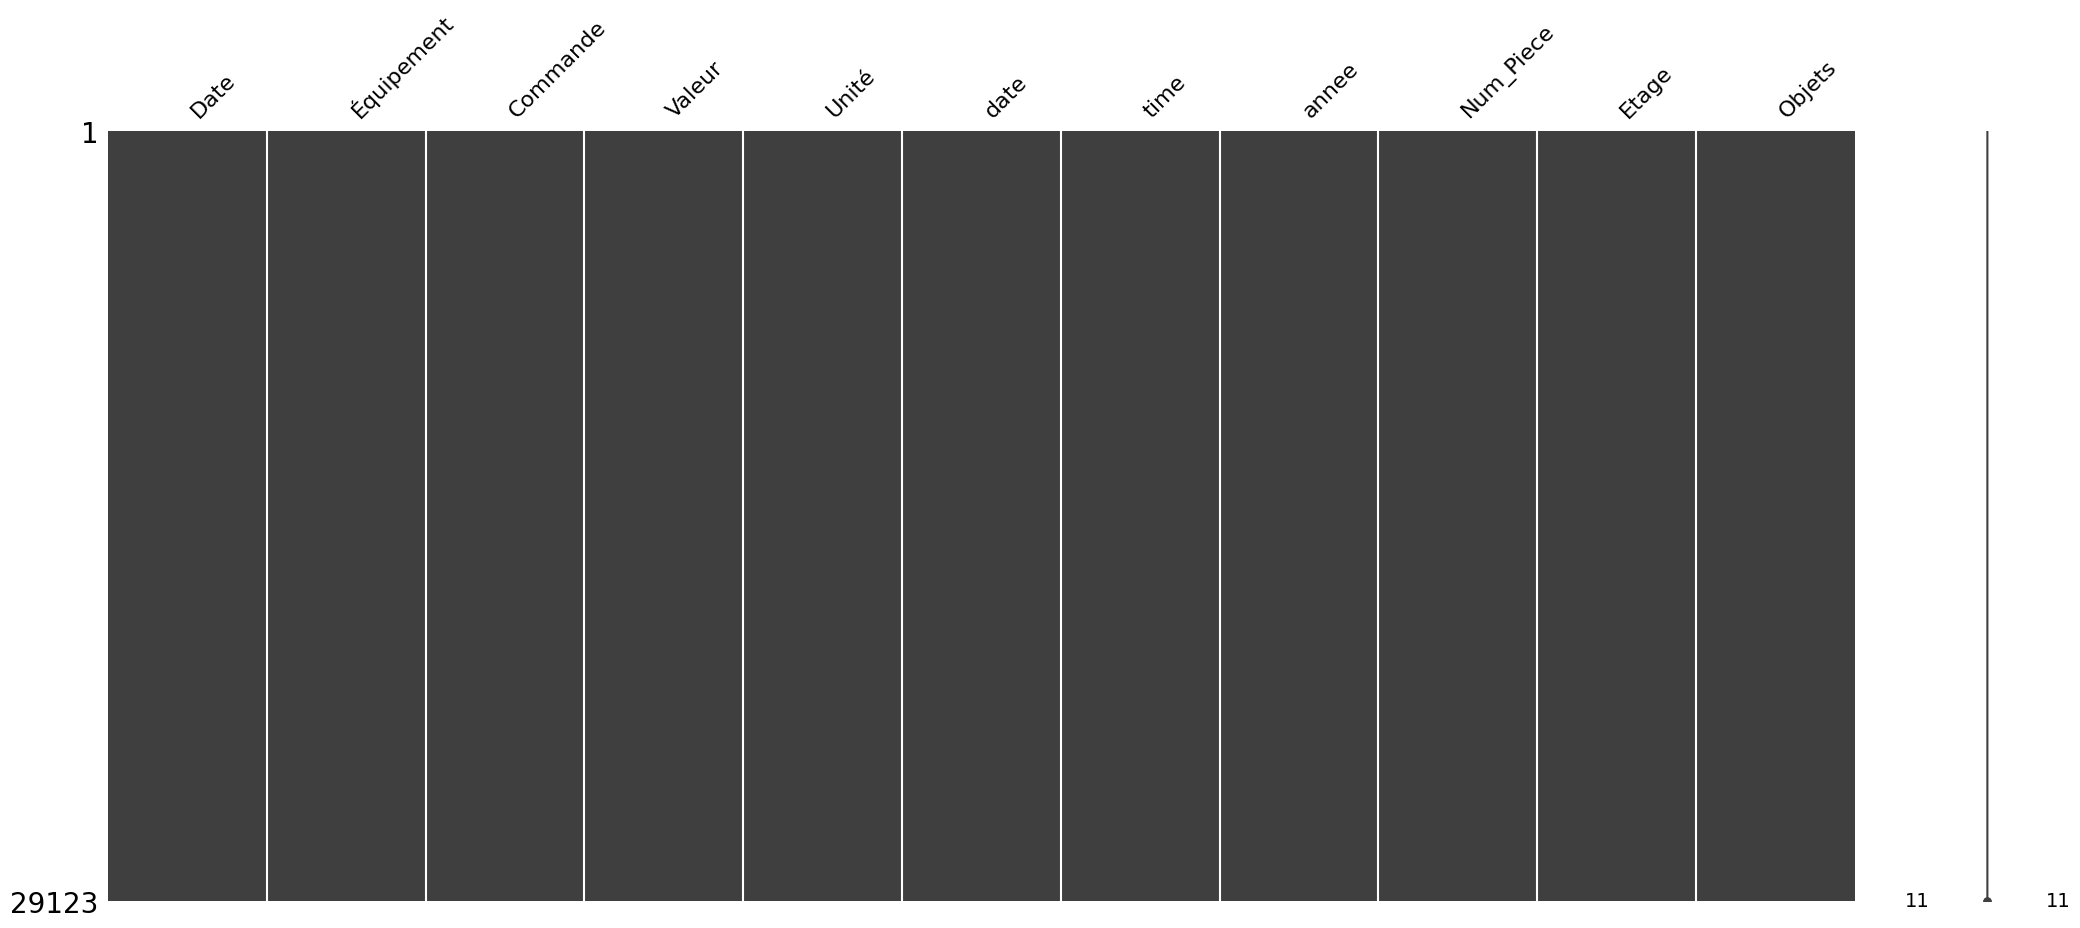

In [75]:
msno.matrix(Tours_Habitat)

Rapport des données nettoyées :

In [76]:
my_report = sv.analyze(Tours_Habitat)

                                             |          | [  0%]   00:00 -> (? left)

In [77]:
my_report.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Rapport des données de Tours Habitat, binaire entre les Années.

In [ ]:
my_report = sv.compare_intra(val_roland, val_roland["Pilote"] == "non piloté", ["Non piloté", "Piloté"])

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
my_report.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
# Vérifier les types de données pour validation
print(val_roland.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43091 entries, 0 to 43090
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Équipement      43091 non-null  object        
 1   Commande        43091 non-null  object        
 2   Type Générique  223 non-null    object        
 3   Valeur          43091 non-null  object        
 4   Unité           43091 non-null  object        
 5   date            43091 non-null  datetime64[ns]
 6   time            43091 non-null  object        
 7   Logement        43091 non-null  object        
 8   Lettre          43091 non-null  object        
 9   Pilote          43091 non-null  object        
dtypes: datetime64[ns](1), object(9)
memory usage: 3.3+ MB
None


In [ ]:
val_roland['Valeur'] = pd.to_numeric(val_roland['Valeur'].str.replace(',', '.'), errors='coerce')